In [1]:
## Serial passaging line plot of MOI 1 experiment up to passage 30, p31-33 at MOI 0.01.

import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from itertools import combinations
import re
from matplotlib.markers import MarkerStyle
import openpyxl

In [2]:
# function that creates a merged df of all samples (pyAccuNGS pipeline)
def get_freqs_pyAccuNGS(input_path):
    freqs_ls = []
    for root, dirs, files in os.walk(input_path):    
        if "freqs.tsv" in files:
            folder_name = root.split("/")[-1]
            freq_path = os.path.join(root, "freqs.tsv")
            freqs = pd.read_csv(freq_path, sep="\t")
            folder_segments = folder_name.split("-")
            passage = int(re.findall(r"\d+", folder_segments[0])[0])
            freqs["passage"] = passage
            if folder_segments[1] == "ravit2021":
                line = folder_segments[0][-1]
            elif folder_segments[1] == "1":
                line = folder_segments[2][-1]
            else:
                line = folder_segments[1][-1]
            freqs["line"] = line
            freqs["mut_name"] = freqs.apply(lambda row: "".join([row["ref_base"], str(row["ref_pos"]), row["read_base"]]), axis=1)
            freqs.rename(columns={"frequency": "freq"}, inplace=True)
            freqs_ls.append(freqs)

    # merge all freqs files
    all_freqs = pd.concat(freqs_ls).reset_index(drop=True)
    return all_freqs

In [3]:

# a function that creates a figure with two plots (one for each line)
def plot_exp(mut_passages, output_path, freq_cutoff, passage_list):
    line_a = mut_passages.loc[mut_passages["line"] == "A", :]
    line_b = mut_passages.loc[mut_passages["line"] == "B", :]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), facecolor="white")
    mutation_list = list(mut_passages.mut_name.drop_duplicates())
    # agreed color library 26/10/23
    colors = {'T1764.0-': '#F50202',
             'A1664.0G': '#fca003',
             'A535.0G': '#5EC0D2',
             'T1440.0C': '#F1F87A',
             'T1440.0G': '#bfbb71',
             'A1443.0G': '#731f1f',
             'A1611.0G': '#6988b8',
             'C1724.0T': '#8FD95A',
             'A1744.0G': '#FBB3DD',
             'G1906.0A': '#A3A3A3',
             'C3358.0T': '#26451C',
             'G3114.0A': '#B37A42',
             'A1770.0G': '#b3b2ad',
             'G2310.0A': '#033E86',
             'A2626.0G': '#8FD95A',
             'C3299.0T': '#211785',
             'C1718.0T': '#4e0d8c',
             'T862.0C': '#880E05',
             'A2790.0T': '#DF36C6',
             'G1736.0A': '#CFFD2F',
             'C1549.0T': '#cd99f2',
             'G531.0A': '#DFC236',
             'C1050.0T': '#0D2291',
             'G1688.0T': '#13B908',
             'A2356.0G': '#2d16f7',
             'T170.0A': '#C60DC3',
             'A1673.0G': '#E2D492',
             'C2859.0T': '#972FFE',
             'T21.0C': 'grey',
             'T323.0A': 'black',
             'G2317.0A': '#E4CEFD',
             'C3378.0T': '#828282',
             'C1735.0T': '#AFF31E',
             'G1560.0A': '#646669',
             'T1829.0C': '#147040',
             'A2731.0G': '#B0F7FF',
             'G710.0A': "#ad8f61", 
             'C1056.0T': "#bd099f", 
             'A784.0G': "#875408", 
             'A1520.0G': "#92bf91",
             'A1829.0G': "#6e465a"}

    handles1, labels1 = plot_line(line_a, "A", mutation_list, ax[0], colors, passage_list)
    handles2, labels2 = plot_line(line_b, "B", mutation_list, ax[1], colors, passage_list)
    handles = handles1 + handles2
    labels3 = labels1 + labels2
    labels = [item.replace(".0", "").replace("T", "U") for item in labels3]
    legend_params = pd.DataFrame({"handles": handles, "labels": labels}).drop_duplicates("labels")
    labels = legend_params["labels"].to_list()
    handles = legend_params["handles"].to_list()
    rep_index = labels.index("U1764-")
    labels[rep_index] = "Δ1764"
    legend_params = pd.DataFrame({"handles": handles, "labels": labels}).drop_duplicates("labels")
    if len(mutation_list) > 14:
        plt.legend(list(legend_params["handles"]), list(legend_params["labels"]), bbox_to_anchor=(1.02, 1.04), loc='upper left', fontsize=17, ncol=2)
    else:        
        plt.legend(list(legend_params["handles"]), list(legend_params["labels"]), bbox_to_anchor=(1.02, 1.04), loc='upper left', fontsize=17)
    plt.subplots_adjust(left=0.07, right=0.7, top=0.9, bottom=0.57, wspace=0.3)

    plot_path = os.path.join(output_path, r"ravit_moi_collapse_line_plot_{}freq.png".format(freq_cutoff))
    plt.suptitle("Mutant Frequencies Over {}%".format(int(freq_cutoff*100)), fontsize=18, fontweight="bold")
    plt.savefig(plot_path)
    plt.show()


# this creates the line plot (used for each line)
def plot_line(line_data, line, mutation_list, ax, colors, passage_list):
    no_color = [mut for mut in mutation_list if mut not in colors]
    extra_colors = generate_colors(no_color)
    
    ### added to set the legend mutations order
    legend_order = ["A1664.0G", "C1718.0T", "C2859.0T", "C1549.0T", "A1744.0G", "T1829.0C", "G1688.0T", "C1735.0T", "A535.0G"]
    muts = []
    for mut in legend_order:
        if mut in mutation_list:
            muts.append(mut)
    for mut in mutation_list:
        if mut not in legend_order:
            muts.append(mut)
            
    for mutation in muts:
        mut_data = line_data.loc[line_data["mut_name"] == mutation, :]
        if not mut_data.empty:
            yvalues = mut_data.iloc[0, 2:].to_list()
            if mutation in colors:
                ax.plot(passage_list, yvalues, label=mutation, marker=".", color=colors[mutation])
            else:
                ax.plot(passage_list, yvalues, label=mutation, marker=".", color=extra_colors[mutation])
    ax.set_xlabel('Time (Passage)', fontsize=23)
    ax.set_ylabel('Mutation Frequency', fontsize=23)
    ax.set_title('Line {}'.format(line), fontsize=23)
    ax.set_xticks(range(0, 36, 5))
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.grid(color='#e1e4e8')
    ax.axvspan(0, 30, color='white')
    ax.axvspan(30, 35, color='#9E9E9F', alpha=0.1)
    ax.set_xlim([0, 35])
    handles, labels = ax.get_legend_handles_labels()
    return handles, labels


# This function generates colors for mutations that don't appear in the 'colors' library
def generate_colors(mut_list):
    cmap_b = matplotlib.colormaps['Dark2']  # Choose 'tab20b' colormap with 20 colors
    cmap_c = matplotlib.colormaps['Set2']  # Choose 'tab20c' colormap with 20 colors
    color_mapping = {}
    for i, mutation in enumerate(mut_list):           
        if i+1 < cmap_b.N:
            color = cmap_b(i+1 % cmap_b.N)
        else:
            color = cmap_c((i - cmap_b.N) % cmap_c.N)
        color_mapping[mutation] = color
    return color_mapping


In [4]:
if __name__ == "__main__":
    input_path = [r"/sternadi/nobackup/volume1/arielle/ravit_original_passaging_pyAccuNGS",
                  r"/sternadi/home/volume3/arielle_k/for_adi/paper_2024/ravit_moi_collapse_freqs.tsv"]
    output_path = r"/sternadi/home/volume3/arielle_k/for_adi/paper_2024"
    freq_cutoff = 0.2   # mutation frequency cutoff

    freqs_to_30 = get_freqs_pyAccuNGS(input_path[0])
    reads_over30 = pd.read_csv(input_path[1], sep="\t")
    freqs_to_30_fil = freqs_to_30.loc[freqs_to_30["passage"] != 30, :]
    reads = pd.concat([freqs_to_30_fil, reads_over30], ignore_index=True)

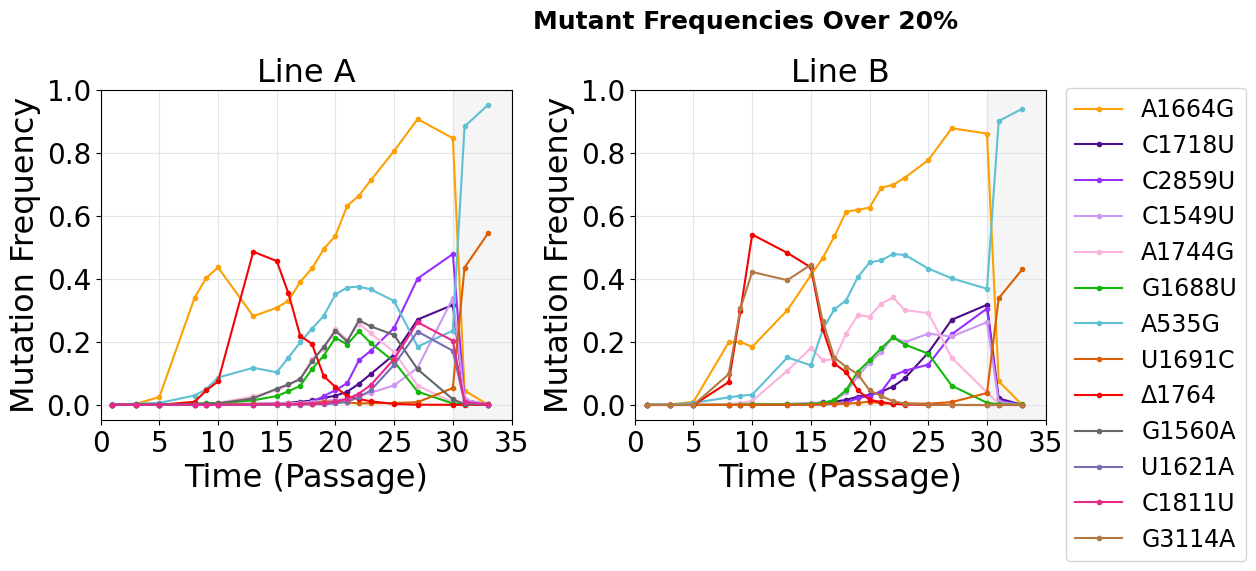

In [5]:
    reads_filtered = reads.loc[(reads["freq"] >= freq_cutoff) & (reads["read_base"] != reads["ref_base"]) &
                               (reads["mut_name"] != "C224.0T") & (reads["mut_name"] != "G1554.0A") &
                               (reads["mut_name"] != "C3299.0T") & (reads["ref_base"] != "-") & 
                               (reads["ref_pos"] > 25) & (reads["ref_pos"] < 3544) & (reads["coverage"] >= 100) & 
                               (reads["ref_pos"] != 3539), :]
    # list of mutations over cutoff in at least one passage
    mut_over_cutoff_list = reads_filtered["mut_name"].drop_duplicates().to_list()
    mut_over_cutoff = reads.loc[(reads["mut_name"].isin(mut_over_cutoff_list)), :].reset_index(drop=True)


    ## create df with freqs per passage
    passages_list = sorted(list(set(mut_over_cutoff["passage"])))
    passages_dfs = []
    for passage in passages_list:
        passages_dfs.append(mut_over_cutoff.loc[mut_over_cutoff["passage"] == passage, ["mut_name", "line", "freq"]]
                            .rename(columns={"freq": "Passage_{}_freq".format(passage)}))

    passages = passages_dfs[0]
    for df in passages_dfs[1:]:
        passages = pd.merge(left=passages, right=df, on=["mut_name", "line"], how="outer")
    passages = passages.drop_duplicates()

    mask = (passages.iloc[:, 2:] >= 0.1).any(axis=1)
    mut_passages = passages[mask]

    # create plot for data
    plot_exp(mut_passages, output_path, freq_cutoff, passages_list)